In [14]:
%load_ext autoreload
%autoreload
import xcf
import keras_nlp
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
AA_VOCAB = ['<PAD>','A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
ACIDS = [aa for aa in AA_VOCAB if aa not in ['<PAD>', 'K','R']]
BASES = [aa for aa in AA_VOCAB if aa not in ['<PAD>', 'D','E']]
NEUTRAL = [aa for aa in AA_VOCAB if aa not in ['<PAD>']]
N_IN_CATEGORY = 1000
MIN_SEQUENCE_LENGTH = 100
MAX_SEQUENCE_LENGTH = 100 #Not counting <START> and <END> tokens

BASELINE_N_LSTM_UNITS = 128
BASELINE_DROPOUT = 0.5
BASELINE_LEARNING_RATE = 0.00001
BASELINE_BATCH_SIZE = 32
BASELINE_EPOCHS = 10

In [3]:
def generate_dummy_proteins(n, min_len, max_len, aas):
    dummy_proteins = []
    for _ in range(n):
        protein = 'M'
        length = random.randint(min_len, max_len)
        for _ in range(length):
            protein = ' '.join([protein, aas[random.randint(0, len(aas)-1)]])
        dummy_proteins.append(protein)

    return dummy_proteins


acidic_dummy_proteins = pd.DataFrame({'seq':generate_dummy_proteins(N_IN_CATEGORY, MIN_SEQUENCE_LENGTH, MAX_SEQUENCE_LENGTH, ACIDS), 'acidity':[np.array([1,0,0]) for _ in range(N_IN_CATEGORY)]})
basic_dummy_proteins = pd.DataFrame({'seq':generate_dummy_proteins(N_IN_CATEGORY, MIN_SEQUENCE_LENGTH, MAX_SEQUENCE_LENGTH, BASES), 'acidity':[np.array([0,1,0]) for _ in range(N_IN_CATEGORY)]})
neutral_dummy_proteins = pd.DataFrame({'seq':generate_dummy_proteins(N_IN_CATEGORY, MIN_SEQUENCE_LENGTH, MAX_SEQUENCE_LENGTH, NEUTRAL), 'acidity':[np.array([0,0,1]) for _ in range(N_IN_CATEGORY)]})
data = pd.concat([acidic_dummy_proteins,basic_dummy_proteins,neutral_dummy_proteins], axis=0)
data.head()

,seq,acidity
0,M P L T C X H G E G O M S D D Y U Q H B I Y H ...,"[1, 0, 0]"
1,M D W S D B E O W B N O W T H Y T I U Q H F B ...,"[1, 0, 0]"
2,M A P Q Y A I X W S I X S Y P O Z Y N L U L T ...,"[1, 0, 0]"
3,M U M Z G V O F F U I E H F O V W M I V H P X ...,"[1, 0, 0]"
4,M N A L Q S Q D U Z F G S X V O H Y Q G C N G ...,"[1, 0, 0]"


In [4]:
data_train, data_val, data_test = xcf.split_df(data)

tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=AA_VOCAB,
    sequence_length=MAX_SEQUENCE_LENGTH,
    oov_token='X'
)

data_train_X = data_train['seq'].to_numpy(dtype='str')
data_val_X = data_val['seq'].to_numpy(dtype='str')
data_test_X = data_test['seq'].to_numpy(dtype='str')

data_train_X = tokenizer(data_train_X)
data_val_X = tokenizer(data_val_X)
data_test_X = tokenizer(data_test_X)

data_train_X_1h = to_categorical(data_train_X,tokenizer.vocabulary_size(),dtype='uint8')
data_val_X_1h = to_categorical(data_val_X,tokenizer.vocabulary_size(),dtype='uint8')
data_test_X_1h = to_categorical(data_test_X,tokenizer.vocabulary_size(),dtype='uint8')

data_train_Y_1h = np.stack(data_train['acidity'].to_numpy())
data_val_Y_1h = np.stack(data_val['acidity'].to_numpy())
data_test_Y_1h = np.stack(data_test['acidity'].to_numpy())

2023-05-07 16:46:49.908545: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-07 16:46:49.908970: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [152]:
%autoreload
lit_LSTM = xcf.models.compile_Liu2017_LSTM(
    tokenizer=tokenizer,
    seq_length=MAX_SEQUENCE_LENGTH,
    n_hidden=BASELINE_N_LSTM_UNITS,
    dropout=BASELINE_DROPOUT,
    lr=BASELINE_LEARNING_RATE
)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 600, 26)]         0         
                                                                 
 masking_9 (Masking)         (None, 600, 26)           0         
                                                                 
 bidirectional_9 (Bidirectio  (None, 256)              158720    
 nal)                                                            
                                                                 
 dense_9 (Dense)             (None, 3)                 771       
                                                                 
Total params: 159,491
Trainable params: 159,491
Non-trainable params: 0
_________________________________________________________________
None


In [153]:
early_stopping = EarlyStopping(patience=3)
history_lit_LSTM = lit_LSTM.fit(
    x=data_train_X_1h, 
    y=data_train_Y_1h, 
    validation_data=(data_val_X_1h, data_val_Y_1h),
    batch_size=BASELINE_BATCH_SIZE, 
    epochs=BASELINE_EPOCHS,
    callbacks=[early_stopping],
)

Epoch 1/10


2023-05-07 16:26:33.361764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-05-07 16:26:34.976198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


75/75 [==============================] - 39s 460ms/step - loss: 1.0969 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - val_loss: 1.0919 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00
Epoch 2/10
75/75 [==============================] - 32s 425ms/step - loss: 1.0646 - precision_7: 0.8163 - recall_7: 0.0167 - val_loss: 0.8211 - val_precision_7: 0.8255 - val_recall_7: 0.5833
Epoch 3/10
75/75 [==============================] - 32s 428ms/step - loss: 0.7603 - precision_7: 0.7440 - recall_7: 0.6029 - val_loss: 0.7476 - val_precision_7: 0.6449 - val_recall_7: 0.5933
Epoch 4/10
75/75 [==============================] - 32s 426ms/step - loss: 0.6752 - precision_7: 0.7494 - recall_7: 0.6242 - val_loss: 0.6222 - val_precision_7: 0.7186 - val_recall_7: 0.6300
Epoch 5/10
75/75 [==============================] - 33s 434ms/step - loss: 0.6216 - precision_7: 0.7593 - recall_7: 0.6662 - val_loss: 0.5503 - val_precision_7: 0.7814 - val_recall_7: 0.7267
Epoch 6/10
75/75 [======================

In [154]:
results = lit_LSTM.predict(x=data_val_X_1h, batch_size=BASELINE_BATCH_SIZE)

10/10 [==============================] - 4s 223ms/step


Learning rate 10 times slower than default helped avoid predicting all zeroes!!!

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        93
           1       0.98      0.96      0.97       106
           2       0.96      0.89      0.92       101

    accuracy                           0.95       300
   macro avg       0.95      0.95      0.95       300
weighted avg       0.95      0.95      0.95       300



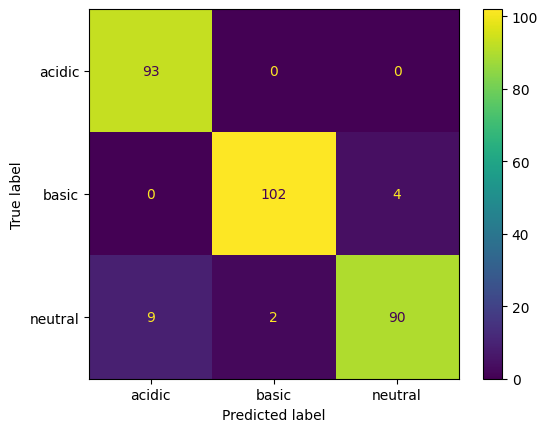

In [155]:
true_labels = data_val_Y_1h.argmax(axis=1)
pred_labels = results.argmax(axis=1)
report = classification_report(true_labels, pred_labels)
conf_matrix = confusion_matrix(true_labels, pred_labels)
conf_matrix_plot = ConfusionMatrixDisplay(conf_matrix, display_labels=['acidic','basic','neutral'])
print(report)
conf_matrix_plot.plot()


In [22]:
def compute_charge(seq):
    charge = 0
    for aa in seq:
        if aa in ['D','E']:
            charge -= 1
        elif aa in ['K','R']:
            charge += 1
    return charge

dummy_proteins = pd.DataFrame({'seq':generate_dummy_proteins(N_IN_CATEGORY*3, MIN_SEQUENCE_LENGTH, MAX_SEQUENCE_LENGTH, NEUTRAL)})
dummy_proteins['charge']=dummy_proteins['seq'].apply(compute_charge)


In [23]:
ch_data_train, ch_data_val, ch_data_test = xcf.split_df(dummy_proteins)

tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=AA_VOCAB,
    sequence_length=MAX_SEQUENCE_LENGTH,
    oov_token='X'
)

ch_data_train_X = ch_data_train['seq'].to_numpy(dtype='str')
ch_data_val_X = ch_data_val['seq'].to_numpy(dtype='str')
ch_data_test_X = ch_data_test['seq'].to_numpy(dtype='str')

ch_data_train_X = tokenizer(ch_data_train_X)
ch_data_val_X = tokenizer(ch_data_val_X)
ch_data_test_X = tokenizer(ch_data_test_X)

ch_data_train_X_1h = to_categorical(ch_data_train_X,tokenizer.vocabulary_size(),dtype='uint8')
ch_data_val_X_1h = to_categorical(ch_data_val_X,tokenizer.vocabulary_size(),dtype='uint8')
ch_data_test_X_1h = to_categorical(ch_data_test_X,tokenizer.vocabulary_size(),dtype='uint8')

ch_data_train_Y = ch_data_train['charge'].to_numpy()
ch_data_val_Y = ch_data_val['charge'].to_numpy()
ch_data_test_Y = ch_data_test['charge'].to_numpy()

In [32]:
%autoreload
ch_lit_LSTM = xcf.models.compile_Liu2017_LSTM_reg(
    tokenizer=tokenizer,
    seq_length=MAX_SEQUENCE_LENGTH,
    n_hidden=BASELINE_N_LSTM_UNITS,
    dropout=BASELINE_DROPOUT,
    lr=BASELINE_LEARNING_RATE
)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 100, 26)]         0         
                                                                 
 masking_6 (Masking)         (None, 100, 26)           0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 256)              158720    
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 1)                 257       
                                                                 
Total params: 158,977
Trainable params: 158,977
Non-trainable params: 0
_________________________________________________________________
None


In [33]:
early_stopping = EarlyStopping(patience=3)
ch_history_lit_LSTM = ch_lit_LSTM.fit(
    x=ch_data_train_X_1h, 
    y=ch_data_train_Y, 
    validation_data=(ch_data_val_X_1h, ch_data_val_Y),
    batch_size=BASELINE_BATCH_SIZE, 
    epochs=BASELINE_EPOCHS,
    callbacks=[early_stopping],
)

Epoch 1/10


2023-05-07 17:03:32.956267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-05-07 17:03:34.985835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


75/75 [==============================] - 13s 111ms/step - loss: 15.4332 - root_mean_squared_error: 3.9285 - val_loss: 16.5383 - val_root_mean_squared_error: 4.0667
Epoch 2/10
75/75 [==============================] - 6s 86ms/step - loss: 15.4284 - root_mean_squared_error: 3.9279 - val_loss: 16.5385 - val_root_mean_squared_error: 4.0668
Epoch 3/10
75/75 [==============================] - 6s 79ms/step - loss: 15.4224 - root_mean_squared_error: 3.9271 - val_loss: 16.5388 - val_root_mean_squared_error: 4.0668
Epoch 4/10
75/75 [==============================] - 6s 80ms/step - loss: 15.4348 - root_mean_squared_error: 3.9287 - val_loss: 16.5390 - val_root_mean_squared_error: 4.0668


In [34]:
ch_results = ch_lit_LSTM.predict(x=ch_data_val_X_1h, batch_size=BASELINE_BATCH_SIZE)

10/10 [==============================] - 2s 41ms/step


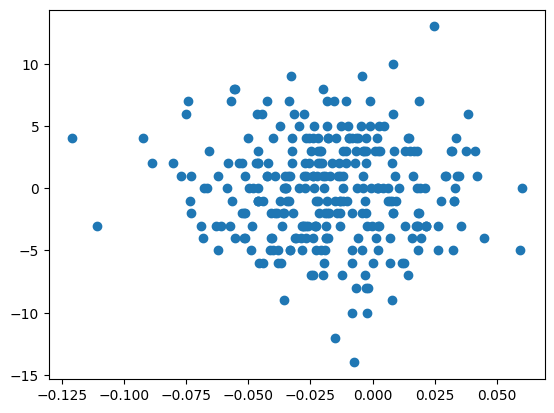

In [35]:
plt.scatter(ch_results, ch_data_val_Y)